# Обучение чат-бота на основе диалогов из фильмов


# 1 Импорт библиотек, установка, настройка

## 1.1 Импорт

In [1]:
from pathlib import Path
import codecs
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

tf.__version__

'2.6.4'

## 1.2 Установка MLFlow

In [2]:
# try:
#     import mlflow
#     print(mlflow.__version__)
# except:
#     print('Устанавливаю MLFlow, не забудь перезапустить ядро. НЕ Factory rest')
#     from IPython.display import clear_output
#     !pip install -U mlflow
#     clear_output(wait=False)
#     import mlflow

#     print('Устанавил и импортировал MLFlow, перезапусти ядро (!)')

## 1.3 Гиперпараметры

In [3]:
HP_DATASET = {'seq_len'                : 100,
              'batch_size'             : 128,  # 64
              'examples_per_epoch'     : None,
              'vocab_size'             : 127,
             }

HP_MODEL = {'lstm_units'                : 512, # 1024 - гайд от tf  # 256
            'embedding_dim'             : 512,  # 256 - гайд от tf  # 256
            'epoch'                     : 100,
            }

## 1.4 Пути и операции с файлами

In [4]:
path_dataset_folder = Path('../input/movie-dialog-tfrecord')

path_data = Path('./data/')

path_models = Path('./models/')
path_backup = Path('./models/BackupAndRestore/')
path_chekpoint = Path('./models/Checkpoint/')

path_mlflow = Path('./mlruns/')
path_tblogs = Path('./tblogs/')
path_img = Path('./img/')


paths = [path_data, path_models, path_backup, path_chekpoint, path_mlflow, path_tblogs, path_img]

for path in paths:
    if os.path.exists(path):
        print(f"Folder {path} exists!")
    else:
        os.makedirs(path)
        print(f"Folder {path} was created.")

Folder data was created.
Folder models was created.
Folder models/BackupAndRestore was created.
Folder models/Checkpoint was created.
Folder mlruns was created.
Folder tblogs was created.
Folder img was created.


In [5]:
model_chats_from_ids = '../input/movie-dialog-tfrecord/models/chars_from_ids'
model_ids_from_chars = '../input/movie-dialog-tfrecord/models/ids_from_chars'
path_model           = '../input/movie-dialog-tfrecord/models/saved_model_2022-08-12_06-05-58'

filename_input_target_ids = f"input_target_ids_len60.tfrecords"
filename_input_target_ids = f"input_target_ids_len200.tfrecords"

filename_model = './saved_model_' + str((datetime.now() + timedelta(hours=3)).strftime("%Y-%m-%d_%H-%M-%S"))

## 1.5 TF Callbacks

In [6]:
current_date = (datetime.now() + timedelta(hours=3)).strftime("%Y-%m-%d_%H-%M-%S")
path_logs = str(Path(path_tblogs / current_date))

callback_tboard = tf.keras.callbacks.TensorBoard(log_dir = path_logs, 
                                                 histogram_freq = 1,
                                                )
                                        
# Остановить обучение автоматически, как метрика перестянет меняться
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      mode='min',
                                                      patience=3)

# Можно прерывать обучение и после восстанавливать его, callback смотрит в указанную папку
backup = tf.keras.callbacks.experimental.BackupAndRestore(path_backup)
# callback_backup = tf.keras.callbacks.BackupAndRestore(path_backup)

# Сохранение лучших результатов обучения
path_ch = Path(path_chekpoint / current_date)
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_ch,
                                                         save_weights_only=False, 
                                                         monitor='loss',
                                                         mode='min',
                                                         save_best_only=True)

2022-08-12 15:16:23.374321: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-12 15:16:23.374362: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-12 15:16:23.437537: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-12 15:16:23.473206: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-12 15:16:23.473363: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


## 2 Загрузка TFRecord & кодировщиков

### 2.1 TFRecord -> Dataset

In [7]:
# Функция для чтения TFRecords
feature_description = {
        'encode_input_seqs'  : tf.io.FixedLenFeature([], tf.string, default_value=''),
        'decode_input_seqs'  : tf.io.FixedLenFeature([], tf.string, default_value=''),
        'decode_target_seqs' : tf.io.FixedLenFeature([], tf.string, default_value=''),
          }

def parse_function(example_proto):
  parsed = tf.io.parse_single_example(example_proto, feature_description)
  return (parsed['encode_input_seqs'], parsed['decode_input_seqs'], parsed['decode_target_seqs'])

In [8]:
%%time
path = str(path_dataset_folder / filename_input_target_ids)

dataset = tf.data.TFRecordDataset(filenames = [path])
dataset = dataset.map(parse_function)
dataset = dataset.map(lambda x, y, z: [tf.io.parse_tensor(x, out_type=tf.int32), 
                                       tf.io.parse_tensor(y, out_type=tf.int32),
                                       tf.io.parse_tensor(z, out_type=tf.int32)])

len_tfr = []
for i in dataset:
    len_tfr.append(i)
print('Набор объёмом:', len(len_tfr))


# ✅ Указываем выходы для сети
dataset = dataset.map(lambda i1, i2, t: ({'encode_input_seqs': i1, 'decode_input_seqs': i2}, t))

for i in dataset.take(1):
    print(i)

2022-08-12 15:16:23.677630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 15:16:23.784321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 15:16:23.785075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 15:16:23.787579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Cause: could not parse the source code of <function <lambda> at 0x7efc8cb88170>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-12 15:16:26.461901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Набор объёмом: 207858
Cause: could not parse the source code of <function <lambda> at 0x7efc8d0e1b00>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
({'encode_input_seqs': <tf.Tensor: shape=(200,), dtype=int32, numpy=
array([34, 63, 76,  1, 85, 67,  1, 75, 63, 73, 67,  1, 82, 70, 71, 81,  1,
       79, 83, 71, 65, 73, 31,  1,  1, 49, 77, 86, 63, 76, 76, 67,  1, 42,
       77, 80, 80, 71, 76, 67,  1, 63, 76, 66,  1, 32, 76, 66, 80, 67, 85,
        1, 33, 63, 80, 80, 67, 82, 82,  1, 63, 80, 67,  1, 70, 63, 84, 71,
       76, 69,  1, 63, 76,  1, 71, 76, 65, 80, 67, 66, 71, 64, 74, 87,  1,
       70, 77, 80, 80, 67, 76, 66, 77, 83, 81,  1, 78, 83, 64, 74, 71, 65,
        1, 64, 80, 67, 63, 73, 13,  1, 83, 78,  1, 77, 76,  1, 82, 70, 67,
        1, 79, 83, 63, 66, 14,  1,  1, 32, 69, 63, 71, 76, 14,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0

In [9]:
# ✅ Настройка dataset для отправки в fit()

dataset = dataset.shuffle(10_000)
dataset = dataset.batch(HP_DATASET['batch_size'])
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset

<PrefetchDataset shapes: ({encode_input_seqs: <unknown>, decode_input_seqs: <unknown>}, <unknown>), types: ({encode_input_seqs: tf.int32, decode_input_seqs: tf.int32}, tf.int32)>

In [10]:
for i in dataset.take(1):
    print(i)

({'encode_input_seqs': <tf.Tensor: shape=(128, 200), dtype=int32, numpy=
array([[40,  1, 73, ...,  0,  0,  0],
       [40,  1, 75, ...,  0,  0,  0],
       [39, 67,  8, ...,  0,  0,  0],
       ...,
       [51, 70, 67, ...,  0,  0,  0],
       [46, 70,  1, ...,  0,  0,  0],
       [56, 77, 83, ...,  0,  0,  0]], dtype=int32)>, 'decode_input_seqs': <tf.Tensor: shape=(128, 200), dtype=int32, numpy=
array([[125,  54,  70, ...,   0,   0,   0],
       [125,  38,  67, ...,   0,   0,   0],
       [125,  45,  77, ...,   0,   0,   0],
       ...,
       [125,  40,   1, ...,   0,   0,   0],
       [125,  54,  70, ...,   0,   0,   0],
       [125,  40,   1, ...,   0,   0,   0]], dtype=int32)>}, <tf.Tensor: shape=(128, 200), dtype=int32, numpy=
array([[54, 70, 63, ...,  0,  0,  0],
       [38, 67, 67, ...,  0,  0,  0],
       [45, 77, 14, ...,  0,  0,  0],
       ...,
       [40,  1, 68, ...,  0,  0,  0],
       [54, 70, 63, ...,  0,  0,  0],
       [40,  1, 72, ...,  0,  0,  0]], dtype=int32)>)


### 2.2 Кодирование и декодирование символов: `ids from char, char from ids`

In [11]:
def string_split(x : str, tags=False):
    # функция для разделения строки на элементы
    # в начале и конце добавляет теги
    if tags:
        splited_string = ['<START>']
        splited_string.extend([*x])
        splited_string.extend(['<END>'])
        return splited_string
        
    return [*x]

In [12]:
ids_from_chars = tf.keras.models.load_model(model_ids_from_chars)
ids_from_chars = ids_from_chars.layers[0]

example_str = string_split('hello world')

ids_from_chars(example_str)

<tf.Tensor: shape=(11,), dtype=int64, numpy=array([70, 67, 74, 74, 77,  1, 85, 77, 80, 74, 66])>

In [13]:
HP_DATASET['vocab_size'] = len(ids_from_chars.get_vocabulary())
HP_DATASET

{'seq_len': 100,
 'batch_size': 128,
 'examples_per_epoch': None,
 'vocab_size': 127}

In [14]:
def string_join(ids):
  return tf.strings.reduce_join(ids, axis=-1).numpy().decode('utf8')

In [15]:
chars_from_ids = tf.keras.models.load_model(model_chats_from_ids)
chars_from_ids = chars_from_ids.layers[0]

example_ids = [70, 67, 74, 74, 77,  1, 85, 77, 80, 74, 66]
example_symb = chars_from_ids(example_ids)

string_join(example_symb)

'hello world'

# 3 Архитектура модели (Functional API)

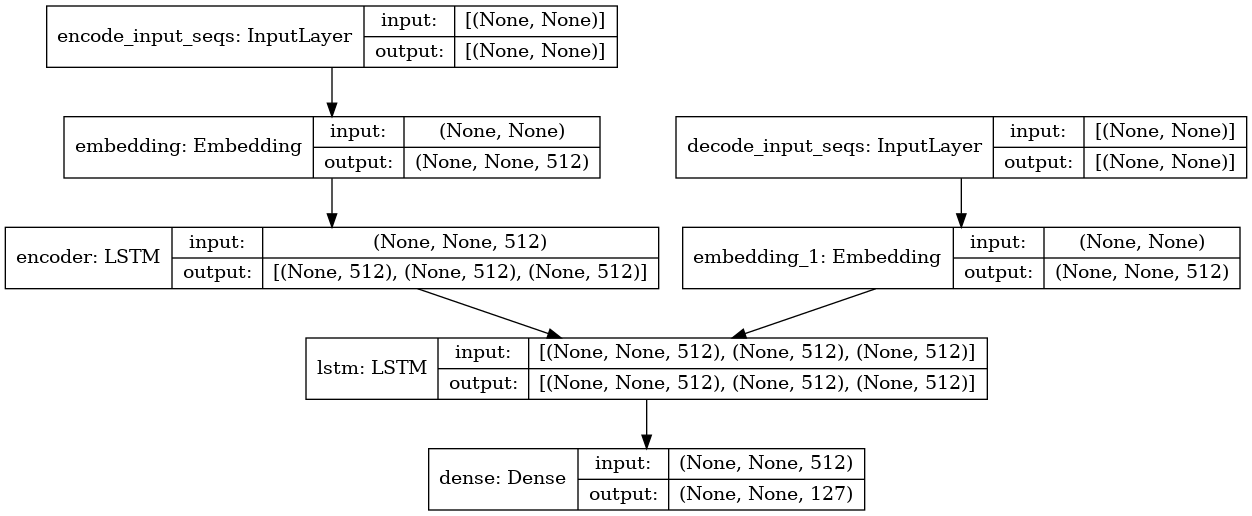

In [16]:
# ✅ Encoder
encoder_input = tf.keras.layers.Input(shape=(None, ),
                               name='encode_input_seqs')

encoder_embedded = tf.keras.layers.Embedding(input_dim         = HP_DATASET['vocab_size'],
                                             output_dim        = HP_MODEL['embedding_dim'],
                                             # Указываем, что есть паддинг - маска
                                             mask_zero         = True)(encoder_input)

_, encoder_state_h, encoder_state_c = tf.keras.layers.LSTM(units                   = HP_MODEL['lstm_units'], 
                                                           # H возвращается, но не весь - только последний элемент.
                                                           return_sequences        = False,
                                                           # C - вернуть своё внутренее состояние
                                                           return_state            = True,
                                                           name                    = 'encoder')(encoder_embedded) 

encoder_state = [encoder_state_h, encoder_state_c]

# ✅ Decoder
decoder_input = tf.keras.layers.Input(shape=(None, ),
                               name='decode_input_seqs')

decoder_embedded = tf.keras.layers.Embedding(input_dim         = HP_DATASET['vocab_size'],
                                             output_dim        = HP_MODEL['embedding_dim'],
                                             mask_zero         = True,)(decoder_input)


decoder_output, decoder_state_h, decoder_state_c = tf.keras.layers.LSTM(units                   = HP_MODEL['lstm_units'],
                                                                   # Нужна вся выходная цепочка
                                                                     return_sequences        = True,                
                                                                    # Нужно возвращать состояние для инференса, чтобы генерировать цепочку.
                                                                    return_state            = True
                                                                )(decoder_embedded, initial_state=encoder_state)  



output = tf.keras.layers.Dense(HP_DATASET['vocab_size'], activation='softmax')(decoder_output)



# ✅ Компиляция и вывод архитектуры: указываются выходы и выходы.
model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=[output])


loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='auto',
    name='sparse_categorical_crossentropy')


# optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop')

metric = tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None)


model.compile(optimizer=optimizer, loss=loss, metrics=[metric]) #optimizer='rmsprop'

tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encode_input_seqs (InputLayer)  [(None, None)]       0                                            
__________________________________________________________________________________________________
decode_input_seqs (InputLayer)  [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    65024       encode_input_seqs[0][0]          
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    65024       decode_input_seqs[0][0]          
______________________________________________________________________________________________

## 4 Обучение модели

## 4.1 Обучение

In [18]:
# %load_ext tensorboard
# %tensorboard --logdir path_logs

In [19]:
history = model.fit(dataset, epochs=HP_MODEL['epoch'],
                    callbacks=[callback_tboard, callback_checkpoint]
                   )

Epoch 1/100


2022-08-12 15:18:01.315885: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


      1/Unknown - 11s 11s/step - loss: 1.1480 - sparse_categorical_accuracy: 0.0102

2022-08-12 15:18:03.582916: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-12 15:18:03.582968: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


      2/Unknown - 11s 678ms/step - loss: 1.1557 - sparse_categorical_accuracy: 0.0929

2022-08-12 15:18:04.044034: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-12 15:18:04.047046: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-12 15:18:04.191980: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3115 callback api events and 3112 activity events. 
2022-08-12 15:18:04.242694: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-12 15:18:04.356844: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tblogs/2022-08-12_18-16-22/train/plugins/profile/2022_08_12_15_18_04

2022-08-12 15:18:04.429503: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tblogs/2022-08-12_18-16-22/train/plugins/profile/2022_08_12_15_18_04/cacc6c8bf708.trace.json.gz
2022-08-12 15:18:04.495363: I tensorflow/core/profiler/rpc/client/save_profi

1624/1624 [==============================] - 169s 98ms/step - loss: 0.3863 - sparse_categorical_accuracy: 0.5149


2022-08-12 15:20:48.984540: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
1624/1624 [==============================] - 159s 97ms/step - loss: 0.3111 - sparse_categorical_accuracy: 0.5944
Epoch 3/100
1624/1624 [==============================] - 158s 97ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.6097
Epoch 4/100
1624/1624 [==============================] - 159s 97ms/step - loss: 0.2902 - sparse_categorical_accuracy: 0.6182
Epoch 5/100
1624/1624 [==============================] - 158s 97ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.6239
Epoch 6/100
1624/1624 [==============================] - 159s 97ms/step - loss: 0.2814 - sparse_categorical_accuracy: 0.6286
Epoch 7/100
1624/1624 [==============================] - 159s 97ms/step - loss: 0.2783 - sparse_categorical_accuracy: 0.6322
Epoch 8/100
1624/1624 [==============================] - 160s 98ms/step - loss: 0.2758 - sparse_categorical_accuracy: 0.6350
Epoch 9/100
1624/1624 [==============================] - 158s 97ms/step - loss: 0.2735 - sparse_categorical_accuracy: 0.6380


In [20]:
# Сохранение текущего состояния модели
filename_model = './saved_model_' + str((datetime.now() + timedelta(hours=3)).strftime("%Y-%m-%d_%H-%M-%S"))
filepath =  str(path_models / filename_model)

tf.keras.models.save_model(model=model, 
                           filepath=filepath,
                           save_format='tf', 
                           include_optimizer=True, )

## 4.2 Сохранение модели

In [21]:
import shutil
shutil.make_archive(base_name='./models', format='zip', base_dir='./models')
shutil.make_archive(base_name='./tblogs', format='zip', base_dir='./tblogs')

'./tblogs.zip'

## 4.3 Визуализация обучения

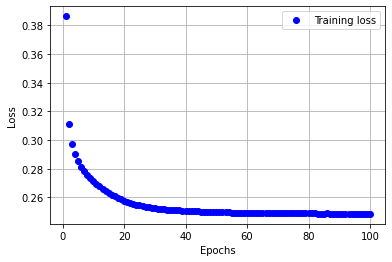

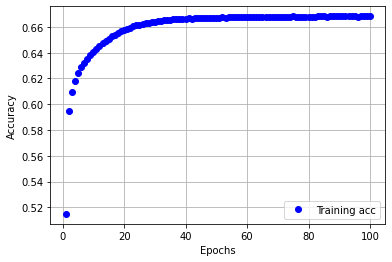

In [22]:
from matplotlib import pyplot as plt

epochs = range(1, len(history.history['sparse_categorical_accuracy']) + 1)

fig = plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
# plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
# plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# plt.savefig(conf.PATH_ARTEFACT/f'25k_2048_30ep_loss.png')

fig = plt.figure()
plt.plot(epochs, history.history['sparse_categorical_accuracy'], 'bo', label='Training acc')
# plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# plt.savefig(conf.PATH_ARTEFACT/f'25k_2048_30ep_accuracy.png')

## 5 Инференс

### 5.1 Загрузка сохранённой модели (+ кодировщик, декодировщик)

In [23]:
def string_split(x : str, tags=False):
    # функция для разделения строки на элементы
    # в начале и конце добавляет теги
    if tags:
        splited_string = ['<START>']
        splited_string.extend([*x])
        splited_string.extend(['<END>'])
        return splited_string
        
    return [*x]

def string_join(ids):
  return tf.strings.reduce_join(ids, axis=-1).numpy().decode('utf8')

In [24]:
# Кодирование
ids_from_chars = tf.keras.models.load_model(model_ids_from_chars)
ids_from_chars = ids_from_chars.layers[0]
example_str = string_split('hello world')
example_str = ids_from_chars(example_str)
print(example_str)

example_tag = ids_from_chars(['<START>'])
print('Стартовый тег:', example_tag)

# Декодирование
chars_from_ids = tf.keras.models.load_model(model_chats_from_ids)
chars_from_ids = chars_from_ids.layers[0]
example_ids = [70, 67, 74, 74, 77,  1, 85, 77, 80, 74, 66]
example_symb = chars_from_ids(example_ids)
print(string_join(example_symb))

# Обученная модель
model_trained = tf.keras.models.load_model(path_model)
model_trained.summary()

tf.Tensor([70 67 74 74 77  1 85 77 80 74 66], shape=(11,), dtype=int64)
Стартовый тег: tf.Tensor([125], shape=(1,), dtype=int64)
hello world


2022-08-12 20:32:20.517909: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-12 20:32:21.079035: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-12 20:32:21.480576: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-12 20:32:21.535433: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-12 20:32:22.147306: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encode_input_seqs (InputLayer)  [(None, None)]       0                                            
__________________________________________________________________________________________________
decode_input_seqs (InputLayer)  [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    65024       encode_input_seqs[0][0]          
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    65024       decode_input_seqs[0][0]          
______________________________________________________________________________________________

## 5.2 Создаём encoder & decoder для инференса
[Инференс основан на блокноте - Colab + копирование весов](https://colab.research.google.com/drive/1FKhOYhOz8d6BKLVVwL1YMlmoFQ2ML1DS#scrollTo=-gUYtOwv21rt)

### Конфигурация Энкодера

In [25]:
# Эмбеддинг энкодера
encoder_emb_weight = model_trained.get_layer(name='embedding').get_weights()
# LSTM энкодера
encoder_lstm_weight = model_trained.get_layer(name='encoder').get_weights()

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
encoder_input = tf.keras.layers.Input(shape=(None, ))
encoder_embedded = tf.keras.layers.Embedding(input_dim         = HP_DATASET['vocab_size'],
                                             output_dim        = HP_MODEL['embedding_dim'],
                                             mask_zero         = True)(encoder_input)
_, encoder_state_h, encoder_state_c = tf.keras.layers.LSTM(units                   = HP_MODEL['lstm_units'], 
                                                           return_sequences        = False,
                                                           return_state            = True,
                                                           name                    = 'encoder')(encoder_embedded) 
encoder_state = [encoder_state_h, encoder_state_c]

# ❗ Выход два обънета с словаре
encoder_model = tf.keras.Model(inputs=[encoder_input], outputs=[encoder_state])
encoder_model.layers[1].set_weights(encoder_emb_weight)
encoder_model.layers[2].set_weights(encoder_lstm_weight)
encoder_model.summary()
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Выход словарь из двух элементов (!)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 512)         65024     
_________________________________________________________________
encoder (LSTM)               [(None, 512), (None, 512) 2099200   
Total params: 2,164,224
Trainable params: 2,164,224
Non-trainable params: 0
_________________________________________________________________


### Конфигурация декодера

In [26]:
# Вход в декодер основная цепочка
decoder_inputs = tf.keras.layers.Input(shape=(None, ))
# Вход в декодер - текущее состояние
decoder_state_input_h = tf.keras.layers.Input(shape=(None, ))
decoder_state_input_c = tf.keras.layers.Input(shape=(None, ))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Эмбеддинг
decoder_embedding = tf.keras.layers.Embedding(input_dim = HP_DATASET['vocab_size'], output_dim= HP_MODEL['embedding_dim'], mask_zero = True,)(decoder_inputs)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Выход из LSTM
decoder_lstm = tf.keras.layers.LSTM(units = HP_MODEL['lstm_units'], return_sequences = True, return_state = True)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
# Текущее состояние слоя
decoder_states = [state_h, state_c]
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Выход из декодера - Полсносявзный - без температуры
decoder_dense = tf.keras.layers.Dense(HP_DATASET['vocab_size'], activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
                              
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Сборка декодера
# Два выходв: цепочка + текущий стейт <START>
decoder_model = tf.keras.Model(inputs  = [decoder_inputs] + decoder_states_inputs,
                               outputs = [decoder_outputs] + decoder_states)


# Веса обученной модели - Embeddings
decoder_embeddings_weight = model_trained.get_layer(name='embedding_1').get_weights()
decoder_model.layers[1].set_weights(decoder_embeddings_weight)
# Веса обученной модели - LSTM
decoder_lstm_weight = model_trained.get_layer(name='lstm').get_weights()
decoder_model.layers[4].set_weights(decoder_lstm_weight)
# Веса обученной модели - DENSE
decoder_dense_weight = model_trained.get_layer(name='dense').get_weights()
decoder_model.layers[5].set_weights(decoder_dense_weight)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 512)    65024       input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

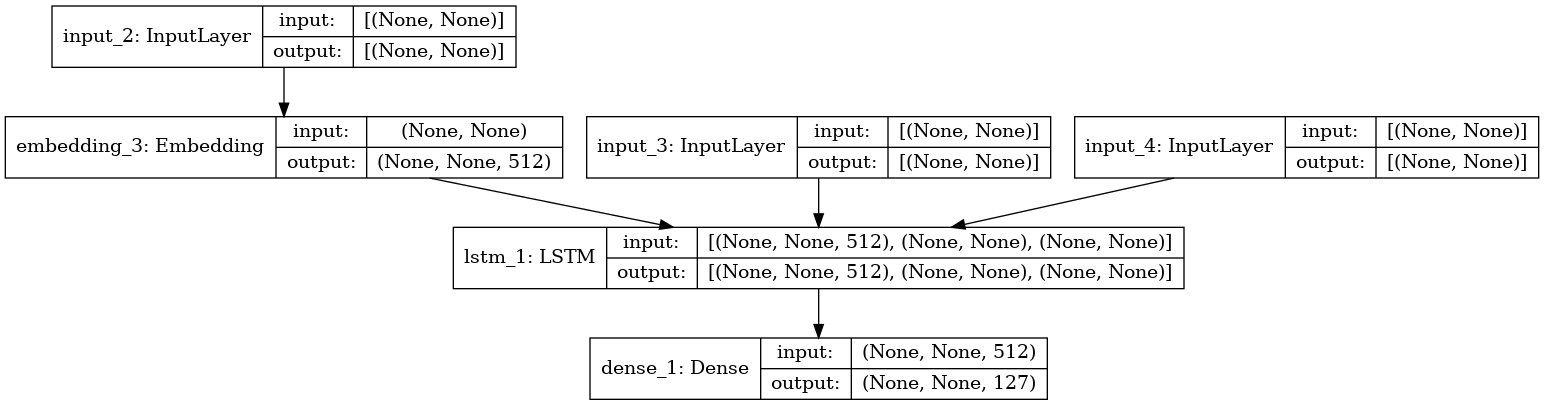

In [27]:
tf.keras.utils.plot_model(decoder_model, show_shapes=True)

# 6. Пример работы чат бота
* часть фраз написаны, часть взята из обучающего датсета

In [28]:
messages = ['Hello! What\'s your name?',
            'Do you alive?',
            'Are you okay?',
            'You always been this selfish?',
            'Did you change your behavior?',
            'I know, your wickedness.',
            'Nobody wants to hurt you Peaches!',
            'Oh. That.  I know what you mean.  I had nightmares all week.',
            'You are guilty.',
            'I believe you. I really do.',
            'Go home'
           ]

for message_str in messages:

    example_str = string_split(message_str)
    example_str = ids_from_chars(example_str)

    for _ in range(1):
        # вызываем encoder получаем h и с
        states_values = encoder_model.predict(example_str)

        # ❗начальное состояние входной цепочки: тег = int 125 из словаря: [125,0,0,...0]
        zeros_len = example_str.shape[0]
        empty_target_seq = np.zeros((zeros_len, 1 ))
        empty_target_seq[0,0] = ids_from_chars(['<START>'])

        stop_condition = True
        ids = []
        stop_num = 0
        while stop_condition:
            #  подаём в декодер текущее состояние: тег + текущее состояние из энкодера
            dec_outputs, h, c = decoder_model.predict([empty_target_seq] + states_values)
            # получаем индекс буквы в словаре
            sampled_char_index = np.argmax(dec_outputs[0, -1, :] )
            # сохраняем полученный символ
            ids.append(sampled_char_index)

            # ❗Обновляем входную цепочки
            # Записываем текущий индекс символа, чтобы подать в декодер на новой итерации
            empty_target_seq = np.zeros((zeros_len, 1 ))
            empty_target_seq[0,0] = sampled_char_index
            # текущее состояние декодера
            states_values = [h,c]

            #  если получили <END> то останавливаемся
            if sampled_char_index == 126:
                stop_condition = False

            stop_num += 1
            if stop_num == 500:
                # Если застряли в цикле остановимся
                stop_condition = False
                print('❗ - Остановка по длине цепочки')


    message_answer = string_join(chars_from_ids(ids))


    print('--------------------------------')
    print(f'YOU ➡️ : {message_str}')
    print(f'Bot ⬅️ : {message_answer}')

--------------------------------
YOU ➡️ : Hello! What's your name?
Bot ⬅️ : 1;I&Q IT'S WAY 2FUCKIN' FUCKING OVER THAT THE FUCKING THE TOLD BIES I WILL ARE YOU YOUR FUCKING ALL IN POODA THE TALKING THAT THE POSTAND CHILERSTAR FUCKING MAN.  NOW YOU KILLED THE APLA VIL ME THIS COULD BERIED OFF MINTING TIME!<END>
--------------------------------
YOU ➡️ : Do you alive?
Bot ⬅️ : Zuzu.  They're the best people who don't know anything about the story.  I was the one who stopped her and they want to be a little surprising.<END>
--------------------------------
YOU ➡️ : Are you okay?
Bot ⬅️ : PRHHINERUME IN THE THIS KNOW THIS IS THERE IN MY 6:35.<END>
--------------------------------
YOU ➡️ : You always been this selfish?
Bot ⬅️ : Doctor Stone?<END>
--------------------------------
YOU ➡️ : Did you change your behavior?
Bot ⬅️ : Zuzu.  They're the best people who don't know anything about the story.  I was the one who stopped her and they want to be a little surprising.<END>
--------------------

## 7 Сохранение результатов

In [29]:
# import shutil
# shutil.make_archive(base_name='./data', format='zip', base_dir='./data')
# shutil.make_archive(base_name='./models', format='zip', base_dir='./models')
# shutil.make_archive(base_name='./tblogs', format='zip', base_dir='./tblogs')
# shutil.make_archive(base_name='mlruns', format='zip', base_dir='./mlruns')